<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### How does cell type and circuit architecture contribute to physiological function?

In the first workshop, we looked at how you might define cell types using unsupervised clustering of high dimensional features. In this workshop, lets assume you have some cell types, some measures of circuit archetecture and measuremetns of physiological function, how might you understand how these things relate?

We will continue to use the MICrONs dataset to explore this question. 

First, we will ask whether or not cell types explain the varied functional correlations between neurons.  In other words, do cells of the same cell type have more similar functional responses, and therefore high signal correlations than cells of different cell types?  To do this, we will measure the correlation of modelled responses of a large number of neurons to a stimulus.  Using modelled responses simplifies this analysis compared to measuring responses directly because the same stimulus was not used on all the neurons in the dataset, and modelled responses (by definition) do not have noise correlations to consider.

Second, we will compare this to whether neurons being synaptically connected to one another changes how functionally similiar they are.  We can ask this question in two ways.  First, just like cell types, does being connected alter the distribution of functional correlations you observe.  Second, does having higher or lower signal correlations change the probability of being connected.  

In the process, we will have a meta-discussion differences between statistical significance and effect size, and discuss how different ways of formulating questions can lead to different impressions on the strength and importance of an effect.

In [1]:
import numpy as np
import os
import platform
import caveclient
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
plat = platform.platform()

In [2]:
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"
    
data_dir = os.path.join(data_root, 'microns_in_silico')


In [3]:
# load up the in-silico responses as a pandas dataframe from a numpy array 
resp=pd.DataFrame(np.load(os.path.join(data_dir, 'nat_resp.npy')))


In [4]:
# this array has 104171 units and 5000 time points
resp.shape

(104171, 5000)

In [5]:
# load up the csv of metadata about the 104171 units
units_df = pd.read_csv(os.path.join(data_dir, 'nat_unit.csv'))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Units dataframe column description

* animal_id: uniformally 17797, this experiment has just one animal
* scan_session: what day the experiment was done on
* scan_idx: what scan on that day was the recording done. NOTE: it is COMBINATION of session and scan which uniquely defines a recording, there are multiple scans with scan_idx =5, 7, 6, and 9. 
* unit_id: an index on the ROIs recording during that session + scan combination.
* row_idx: what is the index of this unit in the response numpy matrix

In [6]:
# my measuring how many rows have a particular scan/session combination we see how many
# ROIs were captured in each recording
units_df[['scan_idx', 'scan_session']].value_counts()

scan_idx  scan_session
5         8               9941
3         7               8618
6         5               8592
4         6               8221
5         7               8194
2         6               8158
7         5               8138
3         9               7973
6         6               7971
7         6               7887
4         9               7855
7         4               7493
6         9               5130
dtype: int64

In [7]:
# set the index to the be the row_idx of the units_df
resp.index = units_df['row_idx']

Text(0, 0.5, 'units')

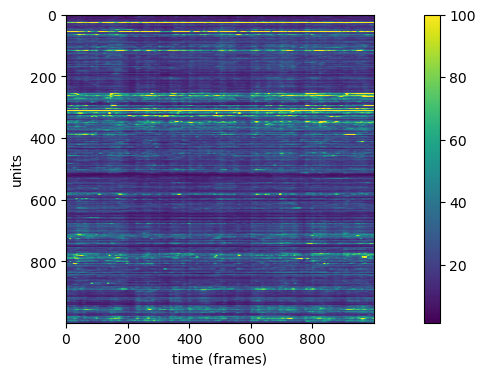

In [8]:
# plot the reponses as a heatmap
f, ax = plt.subplots(figsize=(13,4))

# lets just plot the first 1000 units and first 1000 timepoints
m=ax.imshow(resp.iloc[0:1000,0:1000], vmax=100)
f.colorbar(m)
ax.set_xlabel('time (frames)')
ax.set_ylabel('units')


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Coregistration
Now unfortunately not all of the units were coregistered with structural neurons,
so in order to cull this list of >100,000 ROIs to a list of coregistered ROIs
we need to get data from the CAVE client.

Before running this code, please visit the "CAVESetup" markdown document or notebook, which you only need to run once
 per computer you are setting up, including per CODE ocean capsule you are running, then come back here. 
 

In [10]:
# if we are on code ocean, the CAVEsetup helped you make your token an environment variable
if 'amzn' in plat:
    client= caveclient.CAVEclient('minnie65_public', auth_token=os.environ['API_SECRET'])
else:
    # otherwise if you are local, then it should be saved to a file in your harddrive 
    # that the caveclient knows where to read.
    client= caveclient.CAVEclient('minnie65_public')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Lets get a list of all the table you can query. 
A full description of these tables can be found in the JupyterBook, or in this paper 
MICrONs Consortium et al. Functional connectomics spanning multiple areas of mouse visual cortex. bioRxiv 2021.07.28.454025; doi: https://doi.org/10.1101/2021.07.28.454025


In [11]:
client.materialize.get_tables()

['synapses_pni_2',
 'baylor_gnn_cell_type_fine_model_v2',
 'nucleus_alternative_points',
 'connectivity_groups_v507',
 'proofreading_status_public_release',
 'allen_column_mtypes_v1',
 'allen_v1_column_types_slanted_ref',
 'aibs_column_nonneuronal_ref',
 'nucleus_ref_neuron_svm',
 'aibs_soma_nuc_exc_mtype_preds_v117',
 'baylor_log_reg_cell_type_coarse_v1',
 'apl_functional_coreg_forward_v5',
 'nucleus_detection_v0',
 'aibs_soma_nuc_metamodel_preds_v117',
 'coregistration_manual_v3']

In [12]:
# lets pull out the manual coregistered neurons
# desired_resolution describes how many nanometers you want each unit to be
# so 1000,1000,1000 gives positions in microns for x,y and z
coreg_df = client.materialize.query_table('coregistration_manual_v3', desired_resolution=[1000,1000,1000])

In [14]:
coreg_df.head()

,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,score,pt_position,bb_start_position,bb_end_position
0,582276,2020-09-28 22:41:42.536121+00:00,t,274.291589,111332012547320963,864691135738685297,13434,2023-04-05 22:39:53.474202+00:00,t,582276,7,5,4909,4,6.10722,9.568690,"[1354.88, 500.928, 783.56]","[nan, nan, nan]","[nan, nan, nan]"
1,194144,2020-09-28 22:42:01.511773+00:00,t,213.307228,83542405709639148,864691135614842827,3045,2023-04-05 22:39:03.110911+00:00,t,194144,7,4,9575,6,8.55708,-0.714900,"[545.6, 682.56, 718.04]","[nan, nan, nan]","[nan, nan, nan]"
2,293318,2020-09-28 22:45:23.572432+00:00,t,430.108180,90783515419343652,864691135502985397,1474,2023-04-05 22:36:19.477499+00:00,t,293318,9,4,8066,6,5.63758,8.915025,"[757.888, 477.184, 1041.48]","[nan, nan, nan]","[nan, nan, nan]"
3,332833,2020-09-28 22:44:41.864456+00:00,t,274.418729,93535317407139914,864691135387371905,7915,2023-04-05 22:39:15.451639+00:00,t,332833,6,7,6413,6,5.27806,7.808064,"[837.312, 697.216, 800.16]","[nan, nan, nan]","[nan, nan, nan]"
4,295460,2020-09-28 22:41:24.368712+00:00,t,208.616653,90225718084406516,864691135661410544,11589,2023-04-05 22:39:47.420305+00:00,t,295460,9,3,7748,6,5.20837,2.999543,"[740.352, 631.104, 627.64]","[nan, nan, nan]","[nan, nan, nan]"


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Coregistration columns
* id: a unique index for this coregistration point
* target_id: the nucleus ID for this coregistration (target because its a reference to a nucleus)
* session: the session (aka scan_session from responses)
* scan_idx: the scan index (same as responses)
* unit_id: the unit id in the session+scan (same as responses)
* field: which of the [1-8] 2d fields the unit came from
* residual: a coregistration QC statistic (see paper)
* score: a coregistration QC seperation statistic (see paper)
* pt_root_id: the segmentation id of the object (possible for one segmentation to have 0,1,2+ nuclei)
* pt_position: the x,y,z position of nucleus (in um because of desired_resolution=[1000,1000,1000])
* volume: the volume of the nucleus in um^3
  
Columns you can safely ignore for this exercise
* id_ref: the id of the referenced annotation (in this case a nucleus_id so same as target_id)
* created: when this was created
* created_ref: when the nucleus annotation this references was created
* pt_supervoxel_id: the supervoxel underneath this nucleus location
* bb_start_position: spots for bounding box start (nan in this dataset)
* bb_end_position: spot for bounding boxes end (nan in this dataset)
* valid: an internal check variable

In [15]:
# lets compare how many units there are vs how many are coregistered
units_df.shape, coreg_df.shape

((104171, 5), (13925, 19))

In [16]:
# lets merge these dataframes so we get the row_idx of each coregistered unit
# we merge on the corresponding columns, however scan was called something
# slightly different in one csv vs the CAVE table
coreg_in_silico=pd.merge(units_df, coreg_df, 
         left_on=['scan_session', 'scan_idx', 'unit_id'],
          right_on=['session','scan_idx', 'unit_id'])
# reset the index to make sure that we have the index
coreg_in_silico.reset_index(inplace=True)

In [17]:
coreg_in_silico.head()

,index,animal_id,scan_session,scan_idx,unit_id,row_idx,id_ref,created_ref,valid_ref,volume,...,created,valid,target_id,session,field,residual,score,pt_position,bb_start_position,bb_end_position
0,0,17797,4,7,648,517,516506,2020-09-28 22:44:43.650751+00:00,t,276.767375,...,2023-04-05 22:38:59.933339+00:00,t,516506,4,2,6.181260,11.443982,"[1184.832, 378.752, 632.12]","[nan, nan, nan]","[nan, nan, nan]"
1,1,17797,4,7,662,530,452329,2020-09-28 22:45:02.852190+00:00,t,311.618437,...,2023-04-05 22:39:40.786518+00:00,t,452329,4,2,5.422790,12.006788,"[1076.992, 395.328, 735.28]","[nan, nan, nan]","[nan, nan, nan]"
2,2,17797,4,7,665,533,451461,2020-09-28 22:41:51.543636+00:00,t,263.504036,...,2023-04-05 22:39:41.400499+00:00,t,451461,4,2,1.280470,15.025886,"[1099.456, 376.256, 881.84]","[nan, nan, nan]","[nan, nan, nan]"
3,3,17797,4,7,671,539,420222,2020-09-28 22:45:01.445495+00:00,t,309.882880,...,2023-04-05 22:39:27.234487+00:00,t,420222,4,2,0.704028,21.035651,"[1039.744, 389.44, 678.96]","[nan, nan, nan]","[nan, nan, nan]"
4,4,17797,4,7,682,549,420058,2020-09-28 22:44:36.438460+00:00,t,267.026432,...,2023-04-05 22:36:19.482289+00:00,t,420058,4,2,9.648310,2.794440,"[985.792, 383.424, 634.92]","[nan, nan, nan]","[nan, nan, nan]"


In [20]:
# this will pull out the responses to the coregistered units
# by using the row_idx that was provided in the metadata
coreg_resp = resp.loc[coreg_in_silico.row_idx,:]

In [21]:
coreg_resp

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
row_idx,,,,,,,,,,,,,,,,,,,,,
517,8.714294,8.389205,8.167579,7.922326,7.731493,7.699910,7.696044,7.763541,7.874216,8.218886,...,8.886191,9.099749,8.959373,8.840260,8.866092,8.645774,8.717130,8.399740,8.151719,7.821183
530,27.801888,23.772120,21.403511,20.300020,19.460159,19.303970,19.291639,19.675701,19.841200,20.078215,...,22.167391,22.549530,23.435244,23.955061,25.507168,25.982679,27.404053,27.955248,29.265530,29.859730
533,5.029181,4.715550,4.709803,4.918536,5.084744,5.144980,5.316867,5.525671,5.622572,5.707830,...,5.886825,5.716750,5.566678,5.665825,5.676474,5.553806,5.504263,5.383977,5.386773,5.271792
539,19.187006,17.638605,17.277279,17.071051,18.043854,17.546471,17.737183,18.471426,18.173761,18.924116,...,18.608578,19.038130,19.458437,19.151489,19.813314,21.130903,21.475687,20.790888,20.212690,19.879103
549,16.494297,15.810871,15.374701,15.181810,15.200312,15.775888,15.440752,15.365167,15.109563,14.872916,...,16.204184,16.890104,16.964874,17.272575,17.356541,17.568405,17.582932,17.501421,17.560127,17.116907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104115,30.396935,30.205544,30.442293,30.685919,30.542255,30.797718,30.663494,30.457676,29.880741,28.993006,...,28.096390,28.341227,28.717432,29.410578,29.629999,30.076792,29.460037,29.480841,29.143921,28.903189
104117,25.033997,24.254360,24.907072,24.798740,25.028891,25.475147,25.683020,25.518440,25.751921,25.826054,...,28.609177,27.474386,26.322895,25.849146,24.981836,24.746439,23.905313,23.537638,23.182465,23.079670
104118,10.192926,9.873822,9.830191,9.916515,10.079259,10.000642,10.346350,10.699907,10.866256,11.009747,...,11.300745,11.192842,11.156609,11.303643,11.327475,11.230376,11.181814,11.128323,11.079679,11.057343


In [22]:
# now with a reduced set of units, we can calculate the Pearson correlation
# between their responses
corr_M = np.corrcoef(coreg_resp.values)

Text(0, 0.5, 'unit 2')

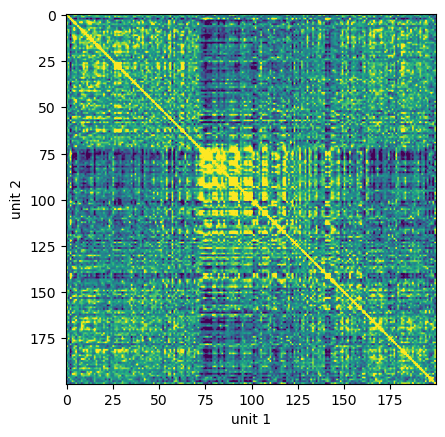

In [23]:
# lets plot the structure
f, ax =plt.subplots()
ax.imshow(corr_M[0:200,0:200], vmin=-.3, vmax=.3)
ax.set_xlabel('unit 1')
ax.set_ylabel('unit 2')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Homework problem: There is some structure here, what does it relate to?
Here we will explore cell types and connectivity, but it could be other things...
### Ideas:
* Simultaneously recorded units?
* Functional sub-networks?
* Variable SNR?
* Variable visual responsiveness?

In [24]:
corr_df = pd.DataFrame(corr_M, index= coreg_resp.index, columns = coreg_resp.index) 
corr_df.head()

row_idx,517,530,533,539,549,553,557,558,568,569,...,104090,104095,104103,104107,104112,104115,104117,104118,104121,104136
row_idx,,,,,,,,,,,,,,,,,,,,,
517,1.000000,-0.061486,-0.098622,0.009170,0.228945,0.291095,0.027640,0.053288,0.168801,-0.131438,...,-0.038276,-0.108614,0.007827,-0.251048,0.192579,0.137946,0.342740,0.004269,-0.072925,0.058063
530,-0.061486,1.000000,-0.140491,-0.033824,0.083964,-0.111129,0.034902,-0.047913,0.190411,0.253458,...,0.314349,0.170561,-0.048066,-0.009829,0.042047,-0.028436,-0.104072,-0.161054,-0.018161,-0.093003
533,-0.098622,-0.140491,1.000000,-0.111408,-0.301957,-0.326235,0.040005,-0.205078,-0.130925,-0.209935,...,-0.172742,0.120892,-0.001427,0.020951,-0.290936,-0.070891,-0.160983,0.604877,0.089123,0.390198
539,0.009170,-0.033824,-0.111408,1.000000,0.106186,-0.040727,0.101713,0.073853,0.098237,0.076004,...,-0.110258,-0.333037,-0.179979,0.348278,-0.104483,0.058801,0.193924,0.090474,-0.117685,-0.372246
549,0.228945,0.083964,-0.301957,0.106186,1.000000,0.179497,-0.035768,0.358460,0.497867,0.028171,...,0.087021,-0.161977,0.279751,0.013717,0.180053,0.281841,0.435491,-0.090973,-0.053730,-0.195957


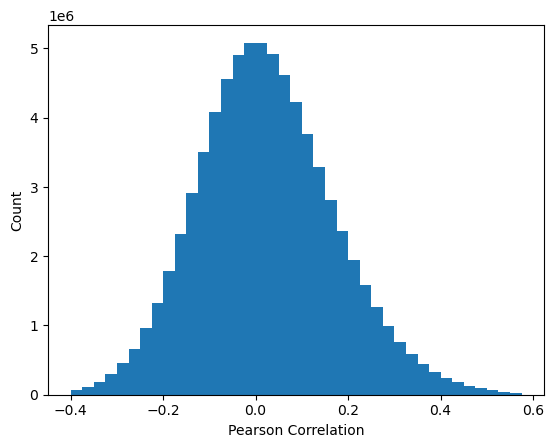

In [26]:
# First thing to do, lets just look at the distribution of correlations

# we only want the upper triangle of the correlation matrix, 
# excluding the diagonal because Pearson correlation of yourself is by definiton 1.
# excluding the lower triangle because Pearson correlation is symettric. 
Cbins = np.arange(-.4,.6,.025)

# this pulls out only the upper trianglur indices from a matrix
# avoiding the diagonal and double counting i vs j, and j vs i. 
Cvals = corr_M[np.triu_indices_from(corr_M,1)]
plt.hist(Cvals, bins=Cbins)
plt.xlabel('Pearson Correlation')
plt.ylabel('Count')
plt.show()


In [28]:
# IN CLASS EXERCISE?
# What is the mean vs std of this distribution?



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## So what about cell types? 
Rather than define our own, lets use a cell type model that is available in MICrONS.  It's based on predicting the lables of the fine grain clustering that was reported in [Schneider-Mizell et al](https://www.biorxiv.org/content/10.1101/2023.01.23.525290v1) on the whole dataset using the soma and nucleus features and classifiers described et [Elabbady et al](https://www.biorxiv.org/content/10.1101/2022.07.20.499976v1). 
 This gives you broader coverage of cell types across the whole dataset. 

In [29]:
ct_df = client.materialize.query_table('aibs_soma_nuc_exc_mtype_preds_v117')

In [30]:
ct_df.head()

,id,created,valid,target_id,classification_system,cell_type,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,35719,2023-02-10 20:56:50.913843+00:00,t,255686,aibs_coarse_excitatory,L3a,255686,2020-09-28 22:40:42.632533+00:00,t,297.846047,88954888800920543,864691135568539372,"[175760, 126480, 15504]","[nan, nan, nan]","[nan, nan, nan]"
1,44755,2023-02-10 20:58:01.326857+00:00,t,524777,aibs_coarse_excitatory,L4b,524777,2020-09-28 22:45:05.521513+00:00,t,316.821012,105637160857796192,864691135355759567,"[297040, 162864, 20055]","[nan, nan, nan]","[nan, nan, nan]"
2,52561,2023-02-10 20:58:57.753550+00:00,t,204945,aibs_coarse_excitatory,L6CT,204945,2020-09-28 22:44:25.115874+00:00,t,250.471875,84466820245155764,864691135208560505,"[142992, 241984, 19204]","[nan, nan, nan]","[nan, nan, nan]"
3,47137,2023-02-10 20:58:15.158371+00:00,t,19116,aibs_coarse_excitatory,L2b,19116,2020-09-28 22:41:51.767906+00:00,t,301.426115,74737997899501359,864691135771677771,"[72576, 108656, 20291]","[nan, nan, nan]","[nan, nan, nan]"
4,38969,2023-02-10 20:57:19.224311+00:00,t,235619,aibs_coarse_excitatory,L6b,235619,2020-09-28 22:41:46.267950+00:00,t,275.799572,86646876455272842,864691135645393647,"[158928, 231792, 15515]","[nan, nan, nan]","[nan, nan, nan]"


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Cell type columns
This has many of the same columns as coregistration,
because its also a reference to a nucleus

but it adds

* cell_type: the cell type string of the cell
* classification_system: a broader cell class description (uniformly aibs_coarse_excitatory here)

In [31]:
# what cell types and how many do we have here?
ct_df.cell_type.value_counts().sort_index()

L2a     3430
L2b     2985
L3a     3264
L3b     2740
L3c     6945
L4a     8312
L4b     3264
L4c     2453
L5ET    2179
L5NP     755
L5a     2228
L5b     3243
L6CT    8526
L6a     2557
L6b     2153
L6c     3590
Name: cell_type, dtype: int64

In [33]:
# lets merge it on the coregistered cells with in silico responses
# we will use the segment version is (pt_root_id) to do this
ct_merge_df=pd.merge(coreg_in_silico.reset_index(),
                     ct_df[['pt_root_id', 'id_ref', 'cell_type']],
                     on='pt_root_id')

In [34]:
# have lost some few cells that we don't have cell types for
ct_merge_df.shape

(11582, 26)

In [35]:
# Lets pick out the cells of particular type
# this is what row of the correlation matrix they are in 
l2index=ct_merge_df.query('cell_type=="L2a"')['index']

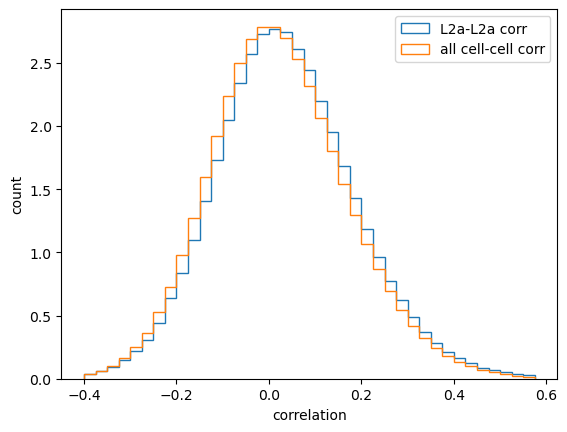

In [37]:
# pull out the values in the correlation matrix for this
# we want only the rows of that index, but all the columns
# and then we filter only those columns, but all the rows
tempc= corr_M[l2index, :][:,l2index]
# plot the distribution of correlations of within the L2a's vs 
# all the cells
import matplotlib.pyplot as plt
plt.hist(tempc[np.triu_indices_from(tempc,1)], bins=Cbins, density=True, histtype='step')
plt.hist(corr_M[np.triu_indices_from(corr_M,1)], bins=Cbins,density=True, histtype='step')
plt.legend(['L2a-L2a corr', 'all cell-cell corr'])
plt.xlabel('correlation')
plt.ylabel('count')
plt.show()


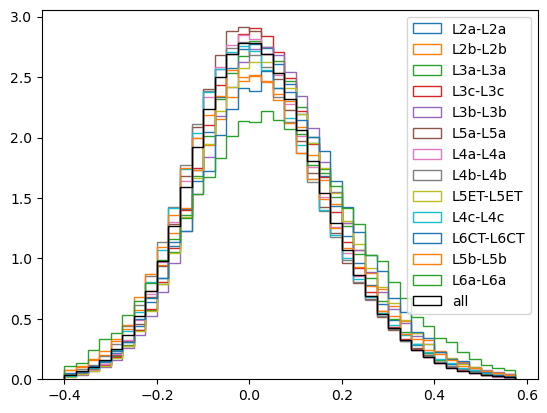

In [38]:
# now what if we repeat this for all the cell types
for cell_type in ct_merge_df.cell_type.unique():
    # pull out the index of the cells of that type
    ctindex=ct_merge_df.query(f'cell_type=="{cell_type}"')['index']

    #reduce the correlation matrix to only include those
    tempc= corr_M[ctindex, :][:,ctindex]

    # lets not include types with only a few examples
    if (len(ctindex)>100):
        plt.hist(tempc[np.triu_indices_from(tempc,1)],
                 bins=Cbins,
                 density=True,
                 histtype='step',
                 label=f'{cell_type}-{cell_type}')

        # lets add in all the correlations for contrast
plt.hist(corr_M[np.triu_indices_from(corr_M,1)],
         bins=Cbins,density=True,
         color='k',
         histtype='step',
         label='all')

plt.legend()

In [39]:
# okay.. so getting even more ambitious
# what if we want to iterate over all cell type interactions

# that's a lot of distributions, so lets just keep track of 
# the mean,  standard deviation and N of each

mean_dfs = []
std_dfs = []
N_dfs = []

# first lets loop over all cell types listed 
# we do it this way to not use too much ram doing it all at once
for cell_type in ct_merge_df.cell_type.unique():

    # as before pull out that cell type
    ctindex=ct_merge_df.query(f'cell_type=="{cell_type}"')['index']

    # but now lets pull the rows of this cell type
    # but all the columns of cells that we have cell type calls for
    tempc  = corr_M[ctindex, :][:,ct_merge_df['index']]

    # we need to get mean avlues across cell type interactions
    # lets setup a dataframe which each cell-cell correlation
    # as its own row, so we can use pivot_table to reduce it

    # here are our correlation values
    vals = tempc.ravel()
    # the cell types on the post-synaptic side come from a matrix
    # where each row has the same set of values
    # then we unravel it into a vector 
    post_types = np.repeat(ct_merge_df.cell_type.values[np.newaxis,:], len(ctindex), axis=0).ravel()
    # our dataframe starts with these two vectors as values
    # but lets get rid of the diagonal same cell to same cell correlations =1.0
    # plus any duplicate cells
    
    dft = pd.DataFrame({'C':vals[vals!=1.0], 'type_post': post_types[vals!=1.0]})
    # the pre-synaptic cell type is always the same
    dft['type_pre']=cell_type

    # now pivot table can help us reduce this to a single value per cell type interaction

    # values will be C that's what we want to average/std/count
    # index will be what the row categories are.. in this case type_pre
    # columns will be what the column categories are.. in this case type_post
    # all the cells that fit in those category combinations will be reduced
    # to one number by the aggfunc, which can be 'mean', 'std', or 'count'
    # to get the mean, standard deviation and count of those distributions
    
    mpt = pd.pivot_table(dft, values = 'C',
                         index='type_pre',
                         columns = 'type_post',
                         aggfunc='mean')
    spt = pd.pivot_table(dft,
                         values = 'C',
                         index='type_pre',
                         columns = 'type_post',
                         aggfunc='std')
    npt = pd.pivot_table(dft, values = 'C',
                         index='type_pre',
                         columns = 'type_post',
                         aggfunc='count')
    # delete some values to save memory
    del(dft)
    del(vals)
    del(tempc)
    # save the dataframes that are 1 row long
    mean_dfs.append(mpt)
    std_dfs.append(spt)
    N_dfs.append(npt)


# now aggregate all those rows into a single dataframe
mean_df=pd.concat(mean_dfs)
std_df = pd.concat(std_dfs)
N_df = pd.concat(N_dfs)




In [40]:
# lets look at what we have got for means
mean_df

type_post,L2a,L2b,L3a,L3b,L3c,L4a,L4b,L4c,L5ET,L5NP,L5a,L5b,L6CT,L6a,L6b
type_pre,,,,,,,,,,,,,,,
L2a,0.037689,0.028996,0.031827,0.041812,0.032897,0.009005,0.015536,0.006038,0.040062,0.043209,0.024932,0.025190,0.039788,0.042831,0.040644
L2b,0.028996,0.040537,0.037968,0.022997,0.024385,0.022426,0.017628,0.019535,0.031448,0.040967,0.025309,0.025411,0.043542,0.036777,0.031651
L3a,0.031827,0.037968,0.041649,0.029666,0.030638,0.021469,0.018030,0.017054,0.036920,0.046289,0.026222,0.022763,0.043109,0.040012,0.037121
L3c,0.032897,0.024385,0.030638,0.039439,0.034503,0.010462,0.016052,0.005994,0.038390,0.046174,0.023684,0.021171,0.034259,0.040092,0.035074
L3b,0.041812,0.022997,0.029666,0.054676,0.039439,0.002564,0.015966,-0.001310,0.046757,0.047934,0.025708,0.025464,0.039097,0.046405,0.044010
L5a,0.024932,0.025309,0.026222,0.025708,0.023684,0.015285,0.016960,0.013009,0.028687,0.037689,0.023014,0.020640,0.031639,0.030696,0.028270
L4a,0.009005,0.022426,0.021469,0.002564,0.010462,0.023781,0.014799,0.021426,0.010124,0.026371,0.015285,0.011791,0.020333,0.015484,0.009571
L4b,0.015536,0.017628,0.018030,0.015966,0.016052,0.014799,0.014869,0.012341,0.018077,0.028846,0.016960,0.014258,0.020858,0.020542,0.016184
L5ET,0.040062,0.031448,0.036920,0.046757,0.038390,0.010124,0.018077,0.004584,0.052053,0.053206,0.028687,0.027151,0.044719,0.047683,0.046532


In [41]:
# lets sort the rows/columns so they are a reasonable consistent order
N_df = N_df.reindex(sorted(N_df.columns), axis=1).sort_index()
std_df = std_df.reindex(sorted(std_df.columns), axis=1).sort_index()
mean_df = mean_df.reindex(sorted(mean_df.columns), axis=1).sort_index()

Text(0.5, 1.0, 'cell type to cell type mean C')

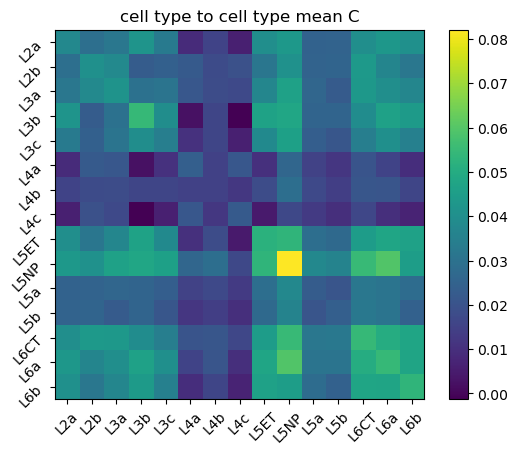

In [42]:
# makes more sense to visualize them as a heatmap
f ,ax = plt.subplots()
m=ax.imshow(mean_df.values)

# we want to see the cell type labels
ticks = ax.set_xticks(np.arange(0, len(mean_df), 1))
ticks = ax.set_yticks(np.arange(0, len(mean_df), 1))
# rotating the labels by 45 degrees helps with colission
ax.set_xticklabels(mean_df.columns, rotation=45)
ax.set_yticklabels(mean_df.index, rotation=45)
f.colorbar(m)
ax.set_title('cell type to cell type mean C')

Text(0.5, 1.0, 'cell type to cell type std C')

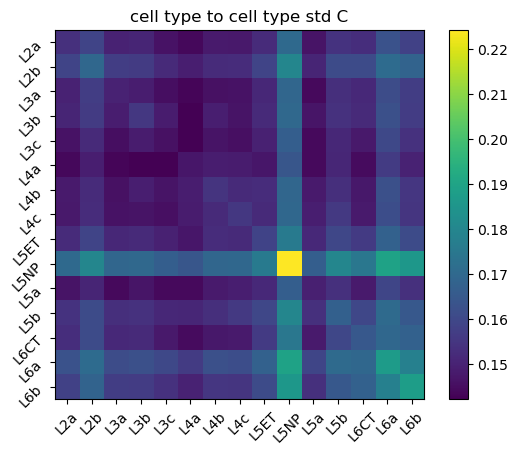

In [43]:
# now some of these distributions might be wider than others
# lets plot the standard deviation
f ,ax = plt.subplots()
m=ax.imshow(std_df.values)
ticks=ax.set_xticks(np.arange(0, len(std_df), 1))
ticks = ax.set_yticks(np.arange(0, len(std_df), 1))
ax.set_xticklabels(std_df.columns, rotation=45)
ax.set_yticklabels(std_df.index, rotation=45)
f.colorbar(m)
ax.set_title('cell type to cell type std C')

Text(0.5, 1.0, 'cell type to cell type mean/std C')

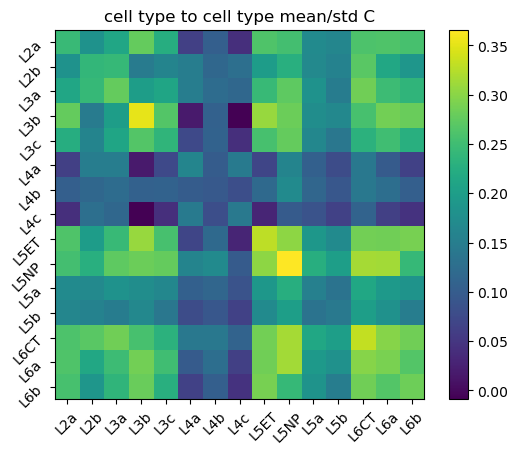

In [44]:
# lets plot the 'effect size' in terms of mean versus std across cell types

f ,ax = plt.subplots()
m=ax.imshow(mean_df.values/std_df.values)
ticks=ax.set_xticks(np.arange(0, len(std_df), 1))
ticks = ax.set_yticks(np.arange(0, len(std_df), 1))
ax.set_xticklabels(std_df.columns, rotation=45)
ax.set_yticklabels(std_df.index, rotation=45)
f.colorbar(m)
ax.set_title('cell type to cell type mean/std C')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Conclusion
This graph is mostly vertically and horizontally banded, with distributions shifted less than 1/2 of a standard deviation. 
This suggests that there is variation in the amount of correlations driven by cell type, 
but its mostly driven by independant sources from either side of the cell types involved
in a comparison, with little interaction effects. Cell types have varying functional patterns, 
but cells of a given type don't appear to syncronize their responses to visual stimuli. 

#### Homework problem
Fit a factorized model of this matrix based on the outer product of a single cell type factor. 

What fraction of the variance of this matrix can be explained by such as simple model?

What drives these systematic differences in correlations? Are responses more diverse or sparser? How would you quantify that?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
### Connectivity

So cell type alone does not explain much about cells functional correlations, other than certain cell types have 
more diverse functional properties that lead to 

In [45]:
# lets pull all the neurons where we can trust the axons
# as being reasonably well reconstructed
prf_df=client.materialize.query_table('proofreading_status_public_release', 
                                      filter_in_dict={'status_axon': ['extended', 'clean']})

In [46]:
# how many of these are coregistered?
clean_coreg_df = pd.merge(prf_df, coreg_in_silico, on='pt_root_id')
clean_coreg_df.shape

(583, 32)

In [47]:
# lets get the subset of the correlation matrix from these neurons
corr_M[clean_coreg_df['index'].values,:].shape

(583, 12094)

In [48]:
# lets load some connectivity data
all_syn_df = pd.read_pickle('all_prf_coreg_conn_v661.pkl')

# see DownloadPrfCoregOutputs for details on where this data came from
# which is basically this code snippet below
# Let's download a summary of all the connections from these neurons to other neurons
# takes about 20 minutes to download the 160K connections
# synapse_dfs = {}
# for k, row in tqdm.tqdm_notebook(clean_coreg_df.iterrows(), total=len(clean_coreg_df)):
#     if synapse_dfs.get(row.pt_root_id, None) is None:
#         syn_df= client.materialize.query_view('connections_with_nuclei', filter_equal_dict={'pre_pt_root_id':row.pt_root_id})
#         synapse_dfs[row.pt_root_id]=syn_df
# for root_id in synapse_dfs:
#     synapse_dfs[root_id].attrs={}
# all_syn_df = pd.concat([synapse_dfs[k] for k in synapse_dfs])
# all_syn_df=all_syn_df.query('pre_nuc_id!=post_nuc_id')


In [49]:
all_syn_df.head()

,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,pre_nuc_id,post_nuc_id
0,864691135927049742,864691136389372944,1,624,265045,298914
1,864691135927049742,864691136687061614,1,3204,265045,272033
2,864691135927049742,864691135472970802,1,1484,265045,232849
3,864691135927049742,864691136310417242,1,1732,265045,303145
4,864691135927049742,864691135498644243,1,3948,265045,256548


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Connection Connectivity Column Descriptions:
* pre_pt_root_id: the segmentation ID of the pre-synaptic compartment
* post_pt_root_id: the segmentation ID of the post-synaptic compartment
* n_syn: how many synapses in this connection
* sum_size: a metric (AU) of the total amount of synaptic area between these neurons. Proportional to connection weight.
* pre_nuc_id: if not -1, then this pre_pt_root_id maps to exactly one cell body with a neuronal nucleus.
* post_nuc_id: if not -1, then this post_pt_root_id maps to exactly one cell body with a neuronal nucleus.

If pre/post_nuc_id = -1 then its either an orphan (i.e. a spine head or axon fragment) or a multi-neuron segmentation object (rare).

In [52]:
# nice to just have a list of all the nuclei and their positions
# I'm just going to pull out 3 columns that we need
# note this asks for positions in units of microns (1000nm per unit in x,y,z)
nuc_df = client.materialize.query_view('nucleus_detection_lookup_v1', 
                                        select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        desired_resolution=[1000,1000,1000])

In [53]:
nuc_df.head()

,id,pt_root_id,pt_position
0,730537,0,"[1525.248, 1095.936, 799.72]"
1,373879,864691136090135607,"[915.264, 959.104, 783.72]"
2,601340,0,"[1360.0, 1116.608, 837.84]"
3,201858,864691135373893678,"[587.392, 854.4, 1050.68]"
4,600774,864691135682378744,"[1356.48, 1104.448, 777.68]"


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Nucleus Table Column descriptions:
Many of these you have seen before, because they were merged automatically for table that referenced them
* **id**: the nucleus id
* **pt_rood_id**: the segmentation id of the nuclues (0 if its outside the segmentation)
* **pt_position**: the position (in microns because desired_resolution=[1000,1000,1000]

In [54]:
# lets merge on the pre and post-synaptic positions of these connections

# renaming the positions as pre and post depending on how we did the merge
# and drop the duplicate id columns
all_syn_dfm=all_syn_df.merge(nuc_df[['id', 'pt_position']], left_on='pre_nuc_id', right_on='id')\
.rename({'pt_position':'pre_pt_position'}, axis=1)\
.merge(nuc_df[['id', 'pt_position']], left_on='post_nuc_id', right_on='id')\
.rename({'pt_position':'post_pt_position'}, axis=1)\
.drop(['id_x', 'id_y'], axis=1)


In [55]:
# now we have positions for the pre and post cells
all_syn_dfm.head()

,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,pre_nuc_id,post_nuc_id,pre_pt_position,post_pt_position
0,864691135927049742,864691136389372944,1,624,265045,298914,"[712.448, 765.376, 884.36]","[739.648, 682.368, 851.16]"
1,864691135700566050,864691136389372944,1,1608,262698,298914,"[705.728, 642.88, 837.2]","[739.648, 682.368, 851.16]"
2,864691135755978194,864691136389372944,2,6136,296680,298914,"[769.216, 630.784, 847.64]","[739.648, 682.368, 851.16]"
3,864691135307704646,864691136389372944,1,6152,260536,298914,"[701.248, 595.392, 828.92]","[739.648, 682.368, 851.16]"
4,864691135777064877,864691136389372944,1,2568,294591,298914,"[765.44, 573.76, 846.28]","[739.648, 682.368, 851.16]"


In [56]:
# now lets merge in the neurons that are coregistered with responses

# we have to drop duplicates to avoid the few cells that were coregistered twice 
# being double counted
all_syn_dfm2=all_syn_dfm.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id', 'score', 'residual']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id','score', 'residual']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])
all_syn_dfm2

,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,pre_nuc_id,post_nuc_id,pre_pt_position,post_pt_position,index_pre,scan_session_pre,...,unit_id_pre,score_pre,residual_pre,index_post,scan_session_post,scan_idx_post,field_post,unit_id_post,score_post,residual_post
0,864691135927049742,864691136310417242,1,1732,265045,303145,"[712.448, 765.376, 884.36]","[742.528, 824.896, 890.64]",1732,5,...,7305,9.837156,9.06328,9470,8,5,8,9995,4.829187,12.58870
1,864691136228183377,864691136310417242,1,7604,299091,303145,"[771.136, 677.056, 895.2]","[742.528, 824.896, 890.64]",9201,8,...,7920,-6.800207,12.60420,9470,8,5,8,9995,4.829187,12.58870
2,864691135122603047,864691136310417242,1,23668,292685,303145,"[772.608, 475.904, 840.84]","[742.528, 824.896, 890.64]",10852,9,...,2231,12.003761,2.79599,9470,8,5,8,9995,4.829187,12.58870
4,864691135155894884,864691136310417242,1,9404,256576,303145,"[661.632, 466.688, 881.28]","[742.528, 824.896, 890.64]",2145,5,...,2177,-3.487494,11.48900,9470,8,5,8,9995,4.829187,12.58870
5,864691135591041291,864691136310417242,2,25900,222998,303145,"[644.672, 473.984, 919.88]","[742.528, 824.896, 890.64]",2091,5,...,1926,2.095723,5.78571,9470,8,5,8,9995,4.829187,12.58870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36266,864691135468161164,864691135661345776,1,8012,553469,420773,"[1273.152, 501.12, 865.92]","[997.12, 417.024, 914.52]",323,4,...,3404,8.345294,4.46736,3987,6,4,2,1381,5.763388,5.06218
36270,864691135468161164,864691135416233914,1,1160,553469,555010,"[1273.152, 501.12, 865.92]","[1292.864, 518.4, 868.76]",323,4,...,3404,8.345294,4.46736,5308,6,6,4,3609,3.216549,10.36870
36278,864691135518453642,864691135645524719,1,3852,610607,261495,"[1382.272, 494.656, 840.6]","[705.152, 687.168, 620.12]",394,4,...,3586,-1.946791,7.53477,5794,6,6,6,6613,6.596697,2.31381
36282,864691136136766845,864691136066510488,1,188,583729,610337,"[1367.744, 515.072, 736.64]","[1418.816, 459.712, 741.36]",8949,8,...,5181,2.960362,5.85307,7950,7,5,2,2048,2.100361,9.59625


In [57]:
# now use fancy indexing to pull out the correlation associated with each of these connections
all_syn_dfm2['C']=corr_M[all_syn_dfm2.index_pre, all_syn_dfm2.index_post]

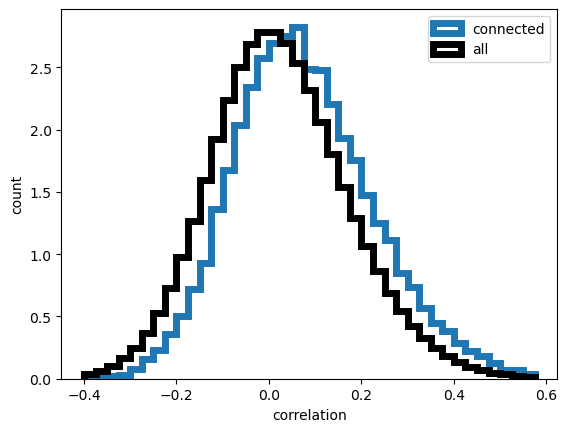

In [58]:
# Lets look at the distribution of these correlations compared to all correlations
Cbins = np.arange(-.4,.6,.025)
plt.hist(all_syn_dfm2.C, bins=Cbins, density=True, linewidth=5,histtype='step', label='connected')
plt.hist(corr_M[np.triu_indices_from(corr_M,1)], linewidth=5, bins=Cbins,color='k',density=True, histtype='step', label='all')


plt.legend()
plt.xlabel('correlation')
plt.ylabel('count')
plt.show()


In [59]:
# now lets merge in our cell type calls
# by using suffixes we will name the pre and post synaptic cell type 
# differently
all_syn_dfm3=all_syn_dfm2.merge(ct_df[['target_id', 'cell_type']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(ct_df[['target_id', 'cell_type']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])


In [63]:
# lets look at our dataframe for the columns we care most about
all_syn_dfm3[['pre_pt_root_id', 'post_pt_root_id', 'n_syn',
              'sum_size', 'C', 'cell_type_pre', 'cell_type_post']].head()

,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,C,cell_type_pre,cell_type_post
0,864691135927049742,864691136310417242,1,1732,0.169119,L5ET,L5ET
1,864691136228183377,864691136310417242,1,7604,0.010837,L4c,L5ET
2,864691135155894884,864691136310417242,1,9404,0.040026,L2a,L5ET
3,864691135591041291,864691136310417242,2,25900,0.145264,L2a,L5ET
4,864691136194822888,864691136310417242,1,9972,0.191115,L4a,L5ET


In [64]:
# now we can use pivot table again to reduce this down to a cell type
# interaction
mean_C_conn=pd.pivot_table(all_syn_dfm3,
                           values='C',
                           index='cell_type_post',
                           columns='cell_type_pre',
                           aggfunc='mean')
N_conn = pd.pivot_table(all_syn_dfm3,
                        values='C',
                        index='cell_type_post',
                        columns='cell_type_pre',
                        aggfunc='count')
std_conn = pd.pivot_table(all_syn_dfm3,
                          values='C',
                          index='cell_type_post',
                          columns='cell_type_pre',
                          aggfunc='std')


Text(0, 0.5, 'Post synaptic type')

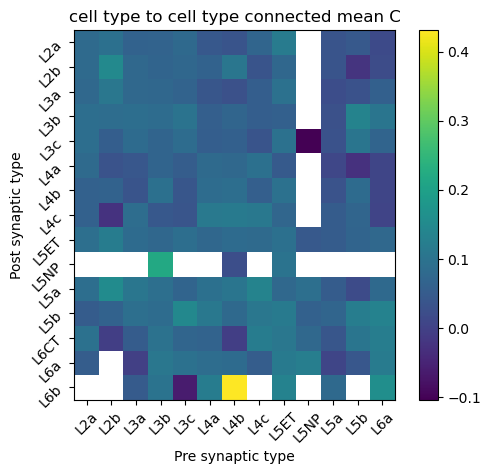

In [66]:
# lets plot the mean correlation

f ,ax = plt.subplots()
m=ax.imshow(mean_C_conn.values)
ticks=ax.set_xticks(np.arange(0, mean_C_conn.shape[1], 1))
ticks = ax.set_yticks(np.arange(0, mean_C_conn.shape[0], 1))
ax.set_xticklabels(mean_C_conn.columns, rotation=45)
ax.set_yticklabels(mean_C_conn.index, rotation=45)
f.colorbar(m)
ax.set_title('cell type to cell type connected mean C')
ax.set_xlabel('Pre synaptic type')
ax.set_ylabel('Post synaptic type')

In [68]:
# In class exercise...
# what other average cell type statistics can you calculate?
# avg number of synapses? avg connection size?


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Conclusions
Compared to the all cells distributions of correlations, these values are uniformly higher, but with little structure driven by  
pre and post synaptic cell types. So being connected appears to drive functional correlations more than sharing cell types. 

### Exercise problems
#### Connections vs Connection Strength
The above analysis we did was not conditioned on connected neurons, but did not consider the strength of that connection. If you weight the distribution by different metrics of strength (either # of synapses or the summed synaptic size) how do the results change?

#### Single cell effects
This aggregates information across a relatively small number of pre-synaptic cells and a large number of post-synaptic cells.  Might the relationship between connection and correlation vary with pre or post-synaptic cell? If certain cells are more visually responsive, or are leaders vs followers, or chorists vs soloists, this might lead to very different synaptic plasticity.  Checking whether individual cells (either pre or post) have more shifted distributions than others could provide some evidence for this.  Keep in mind that the number of connection reconstructed will effect the statistical power you have to detect changes of different sizes.

#### Space
This analysis does not take into account physical space.  If neurons near each other have more similar functional properties, and neurons near to one another are more likely to be connected, this effect might be explained just by spatial factors. How big are those effects? Can they explain this shift?
